# **Assignment \#1**: Machine Learning MC886
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2020s2

**Group**:
- Bruno Benitez de Carvalho (167920)
- Eduardo Barros Innarelli (170161)


---

If you're using Google Colab, connect it with Google Drive to have access to the datasets:

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Go to the assignment directory (it depends on where it's saved in your Drive)
% cd '/content/drive/My Drive/[MC886] Assignments/Assignment 1'
! ls

/content/drive/My Drive/[MC886] Assignments/Assignment 1
2020s2-mc886-assignment-01.ipynb  diamonds-test.csv  diamonds-train.csv


---

## Objective 

Explore **linear regression** alternatives and come up with the best possible model to the problems, avoiding overfitting. In particular, predict the **price of diamonds** from their attributes (e.g., depth, clarity, color) using the Diamonds dataset (https://www.kaggle.com/shivam2503/diamonds)

## Dataset

The Diamonds dataset contains the prices and attributes of almost 50,000 diamonds.

Dataset Information: You should respect the following training/test split: 45,000 training examples, and 5,000 test examples.

There are 9 attributes as follows: 

- 1: **carat**: weight of the diamond (0.2-5.01)
- 2: **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- 3: **color**: diamond color, from J (worst) to D (best)
- 4: **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- 5: **x**: length in mm (0-10.74)
- 6: **y**: width in mm (0-58.9)
- 7: **z**: depth in mm (0-31.8)
- 8: **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
- 9: **table**: width of top of diamond relative to widest point (43-95)


target **price**: price in US dollars

The data is available at
https://www.dropbox.com/s/tmz8bkocrpfmfb9/diamonds-dataset.zip


## Deadline

Monday, October 12th 7 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you did, your grade will be penalized as follows:
- October 13th 7 pm : grade * 0.75
- October 14th 7 pm : grade * 0.5
- October 15th 7 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**

## Dependencies

In [ ]:
# For efficient array manipulation
import numpy as np

# For data analysis & manipulation
import pandas as pd

# For data visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For training models
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# For ignoring some sklearn warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# For training progress visualization
from tqdm import tqdm

# For time tracking
from time import time

---
**Note**: the part of the text relative to what Sandra asked in the assignment is quoted and highlighted.

## **Activity 1.** Linear Regression (4 points) 

> **Perform Linear Regression. You should implement your solution and compare it with ```sklearn.linear_model.SGDRegressor``` (linear model fitted by minimizing a regularized empirical loss with SGD, http://scikit-learn.org). Keep in mind that friends don't let friends use testing data for training :-)**


### **1.1.** Load and preprocess your dataset.

In this step we will define some functions to pre-process both the training and the test sets.

In [ ]:
# Load training dataset
data = {
    'train':pd.read_csv("diamonds-train.csv"),
    'test': pd.read_csv("diamonds-test.csv")
}

The dimensionality features can be combined into a new volume feature and be dropped.

In [ ]:
def convert_dim_into_vol(df):
  ''' 
  Function that converts the dimensions 'x', 'y' and 'z' into a single
  volume feature in the diamonds dataframe, returning the modified
  dataframe.
  '''

  # Create new feature
  df['vol'] = df['x']*df['y']*df['z']

  # Drop dimensions (axis=1 tells pandas to drop columns)
  df.drop(['x', 'y', 'z'], axis=1, inplace=True)

  return df


In [ ]:
# Trigger conversion for both sets
data = {k: convert_dim_into_vol(df) for k, df in data.items()}

# Assert number of columns in dataframe after reduction
assert len(data['train'].columns) == 8

# Show descriptive analysis
data['train'].describe()

,carat,depth,table,price,vol
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.797932,61.745629,57.456700,3933.763022,129.753118
std,0.473871,1.425219,2.237483,3987.830151,76.463311
min,0.200000,43.000000,43.000000,326.000000,0.000000
25%,0.400000,61.000000,56.000000,952.000000,65.288325
50%,0.700000,61.800000,57.000000,2401.000000,114.785402
75%,1.040000,62.500000,59.000000,5330.000000,170.914509
max,5.010000,78.200000,95.000000,18823.000000,790.133208


Note that there are diamonds with `vol = 0` (`min` row). We can drop them, as they aren't relevant to our model.

In [ ]:
def drop_null_vol_rows(df):
  '''
  Function that drop the rows where volume is 0 in the diamonds dataframe, 
  returning the modified dataframe.
  '''

  # Get index of rows where vol is 0
  indexes = df[df['vol'] == 0].index

  # Drop these rows
  df.drop(indexes, inplace=True)

  return df


In [ ]:
# Call drop function for both sets
data = {k: drop_null_vol_rows(df) for k, df in data.items()}

# Assert that these rows were correctly dropped
assert len(data['train'][data['train']['vol'] == 0]) == 0

Now, we have to convert the categorical features `cut`, `color` and `clarity` into numbers, in order for the model to process them. As the categorical features of this problem are ordinal, we can use Label Encoding to achieve that. 

These features categories aren't alphabetically ordered from worst to best. To keep their natural order after encoding, we manually define custom mapping dictionaries and use the pandas replace function.

In [ ]:
def encode_categories(df):
  ''' 
  Function that label encode the categorical features 'cut', 'color' and
  'clarity' in the diamonds dataframe, returning the modified dataframe.  
  '''

  # Label encode 'cut'
  cut_mapping = {
      "Fair": 0, 
      "Good": 1, 
      "Very Good": 2, 
      "Premium": 3, 
      "Ideal": 4
  }
  df = df.replace({"cut": cut_mapping})

  # Label encode 'color'
  color_mapping = {
      "J": 0, 
      "H": 1, 
      "I": 2, 
      "G": 3, 
      "F": 4, 
      "E": 5, 
      "D": 6
  }
  df = df.replace({"color": color_mapping})

  # Label encode 'clarity'
  clarity_mapping = {
      "I1": 0, 
      "SI2": 1, 
      "SI1": 2, 
      "VS2": 3, 
      "VS1": 4, 
      "VVS2": 5, 
      "VVS1": 6, 
      "IF": 7
  }
  df = df.replace({"clarity": clarity_mapping})

  return df


In [ ]:
# Trigger encoding in both sets
data = {k: encode_categories(df) for k, df in data.items()}

# Assert types
for dtype in data['train'].dtypes:
  assert dtype in ['int64', 'float64'] 

Finally, we normalize all the data by dividing each cell by the maximum value in it's column to potentially accelerate the gradient descent method, and detach the training features $X$ and targets $y$. The targets are also scaled to avoid large prediction errors, which could make the learning process unstable.

[Click here](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) for a nice reference about data scaling.

In [ ]:
def normalize_data(df):
  '''
  Function that normalizes a dataframe to 0-1 range, returning the modified
  dataframe.
  '''

  # Divide each cell by it's column maximum value
  for col in df.columns:
    df[col] = df[col] / np.max(df[col])

  return df


In [ ]:
# Normalize data in both sets
data = {k: normalize_data(df) for k, df in data.items()}

# Detach training and test features
X = data['train'].drop(columns='price')
X_test = data['test'].drop(columns='price')

# Detach training and test targets
y = data['train']['price']
y_test = data['test']['price']

The dataset is now ready for training!

In [ ]:
print('Pre-processed features (5 examples):')
display(X.head())

print('\nTargets (5 examples):')
display(y.head())

Pre-processed features (5 examples):


,carat,cut,color,clarity,depth,table,vol
0,0.323353,1.00,0.333333,0.428571,0.794118,0.578947,0.338795
1,0.059880,0.75,0.500000,0.285714,0.751918,0.631579,0.062114
2,0.273453,1.00,0.666667,0.571429,0.762148,0.600000,0.287377
3,0.065868,0.00,0.166667,0.714286,0.832481,0.621053,0.068321
4,0.063872,0.50,0.666667,0.428571,0.751918,0.652632,0.065809



Targets (5 examples):


0    0.557881
1    0.030495
2    0.618871
3    0.048983
4    0.031982
Name: price, dtype: float64

### **1.2.** Linear Regression manual implementation.

First, assume our pre-processed dataset have $m$ training examples (rows) and $n$ feature types (columns). To facilitate later, let:

\begin{align}
\hat{X} & = (\vec{1}_{m \times 1} | X) \\
\end{align}

This is a concatenation between a $m \times 1$ array of ones and $X$.


In [ ]:
# Concatenate y-intercept column
X_hat = pd.concat([pd.Series(1, index=X.index, name='intercept'), X], axis=1)

Before writing the gradient descent (GD) algorithm, we must define some functions it uses, such as the hypothesis and the cost functions. 

**Hypothesis**: function that maps a input into a approximation of the the unknown target. It can be vectorized into a $m \times 1$ array as follows, being $\theta$ the function coefficients:

\begin{align}
h_{\theta}(\hat{X}) & = \hat{X} \theta \\
\end{align}

The column filled with ones we added earlier represents the *y*-intercept term in the hypothesis.   

[Click here](https://medium.com/analytics-vidhya/vectorized-implementation-of-gradient-descent-in-linear-regression-12a10ea37210) for a nice reference about gradient descent vectorization. We chose to implement this way as it's cleaner and speeds up the Python code.  

In [ ]:
# Define hypothesis function
h = lambda X_hat, theta : X_hat @ theta

**Cost**: function that measures the model error to be minimized by the algorithm. To punish large errors in prediction, we opted to use the Mean Square Error (MSE) cost function, vectorized ($m \times 1$) as:

\begin{align}
J_{X,y}(\theta) & = \frac{1}{2m}({h_{\theta}(\hat{X})} - y)^2 \\
\end{align}


In [ ]:
# Define cost function
J = lambda theta, X_hat, y : (1/2) * np.mean(np.square(h(X_hat, theta) - y))

The vector of partial derivatives of $J$ with respect to the parameters $\theta$ (a.k.a. gradient) indicates in which direction the algorithm should move to minimize $J$. More specifically, the direction of the negative gradient points to the minimum cost, which can be reached by decrementing the vector magnitude from $\theta$. Thus, we have the **gradient descent** step, also defined in a vectorized ($n \times 1$, $n$ being the number of columns) manner:

\begin{align}
\theta & := \theta - \alpha\frac{1}{m}\hat{X}^T(h_{\theta}(\hat{X}) - y) \\
\end{align}

Where $\alpha$ is a hyperparameter that corresponds to a learning rate and is usually very small, to ensure that the method will converge. We can also choose for how many rows to compute the gradient in each epoch iteration by splitting the dataset into batches. This affects the algorithm convergence time and "smoothness", which we will analyze further in the last activity.

In [ ]:
def get_batches(df, batch_size):
  '''
  Function that shuffles the data rows and split them into batches of size
  `batch_size`, returning an array of these batches. 
  '''

  # Shuffle training data, if we want to split it
  shuffled = df.sample(frac=1) if len(df) > batch_size else df

  # Return splitted data
  return shuffled.groupby(np.arange(len(df))//batch_size)


We are now ready to implement and run the method itself. Notice that we split the dataset into two at the beginning, one for training with $\frac{2}{3}$ of the examples and other for validation with $\frac{1}{3}$.

In [ ]:
def gd_regression(X_hat, y, alpha=0.01, n_epochs=15000, batch_size=None):
  '''
  Gradient descent method that updates the parameters of a model for a 
  regression problem with a MSE cost function, returning a tuple with the 
  fitted parameters and all epochs training and validation costs.
  '''

  train_history = []
  val_history = []

  # By default, run a full-batch GD
  if batch_size is None:
    batch_size = len(X_hat)

  # Split training and validation set
  X_hat_train, X_hat_val = np.split(X_hat, [int((2/3) * len(X_hat))])
  y_train, y_val = np.split(y, [int((2/3) * len(y))])

  # Initialize theta with zeros
  theta = np.array([0]*len(X_hat.columns))

  for i in tqdm(range(n_epochs), position=0, unit='epoch'):

    # We shuffle X_hat_train and y_train concatenated, to generate stable 
    # batches
    concat_data = pd.concat([X_hat_train, y_train], axis=1)
    batches = get_batches(concat_data, batch_size)

    for (_, batch) in batches:

      # Detach X_hat_train and y_train portions from batch
      X_hat_batch = batch.drop(columns='price')
      y_batch = batch['price']

      # Update parameters
      gradient = (1/batch_size) * (
          X_hat_batch.T @ (h(X_hat_batch, theta) - y_batch)
      )
      theta = theta - alpha * gradient

      # Save new training and validation costs
      train_history.append(J(theta, X_hat_train, y_train))
      val_history.append(J(theta, X_hat_val, y_val))

  return theta, train_history, val_history


In [ ]:
# Run gradient descent algorithm
sol = gd_regression(X_hat, y)

# Detach solution
gd_lr_theta, lr_train_history, lr_val_history = sol

100%|██████████| 15000/15000 [04:55<00:00, 50.68epoch/s]


With the training and validation history in hands, we can plot them together to evaluate the fitted model.

In [ ]:
def plot_cost_history(train_history, val_history):
  '''
  Function that plots the training and validation cost per iteration curves side
  by side. 
  '''

  iterations = range(1, len(train_history) + 1) 
  plt.plot(iterations, train_history, 'r--')
  plt.plot(iterations, val_history, 'b-')
  plt.legend(['Training Cost', 'Validation Cost'])
  plt.xlabel('Iteration')
  plt.ylabel('Cost')
  plt.show()


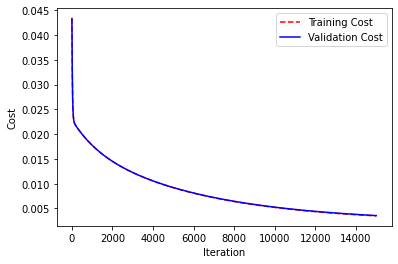

Last training cost: 0.0034709954557405175
Last validation cost: 0.0035383108462760733


In [ ]:
# Visualize cost history
plot_cost_history(lr_train_history, lr_val_history)

# Print last training and validation costs
print(f'Last training cost: {lr_train_history[-1]}')
print(f'Last validation cost: {lr_val_history[-1]}')

The train and validation curves are very close to each other, which indicates that the model didn't overfit to the training data. To see if the model generalizes well for the problem, let's check how it performs on the test set.

In [ ]:
# Concatenate y-intercept column in test set to evaluate cost
X_hat_test = pd.concat(
    [pd.Series(1, index=X_test.index, name='intercept'), X_test], axis=1
)

# Print test cost
print(f'Test cost: {J(gd_lr_theta, X_hat_test, y_test)}')

Test cost: 0.0049475396921107966


Fortunately, the test cost is close to the training and validation costs, which shows that the trained model generalized well.

### **1.3.** Linear Regression scikit-learn implementation.

Lastly, we'll compare our implementation with the one provided by the `scikit-learn` library, more specifically with `sklearn.linear_model.SGDRegressor`. To make a fair comparison, we'll use the same hyperparameters we used in the manual implementation.

In [ ]:
# Initialize model
model = SGDRegressor(
    alpha=0.01, 
    max_iter=15000, 
    n_iter_no_change=15000 # no stopping criteria
)

# Ignore convergence warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Store actual time to calculate train execution time
start = time()
print('Training...')

# Fit the data (train the model)
model.fit(X, y)

# Show execution time
print(f'Train completed after {time() - start}s.\n')

# See how it performs on the training and test data (divide MSE by 2 as that's
# the actual cost function we used)
print(f'Training cost: {mean_squared_error(y, model.predict(X)) / 2}')
print(f'Test cost: {mean_squared_error(y_test, model.predict(X_test)) / 2}')

Training...
Train completed after 98.47721433639526s.

Training cost: 0.005390928449575417
Test cost: 0.0053151983366235426



> **What are the conclusions? (1-2 paragraphs)**

Using the same parameters, i.e. alpha and number of epochs, we can see that our implementation of Gradient Descent is approximately 3 times slower than the `scikit-learn` routine; 292s versus 95s. However, our manual implementation hit a better score at training and testing costs. Here are the results:

  - Manual training cost: 0.0034709954557405175, versus sklearn training cost: 0.005390345582451047. 
  - Manual testing cost: 0.0049475396921107966, versus sklearn testing cost: 0.005346963216568733.

Since we have no goal of error to reach and we are trying to hit a number very close to zero, we can say that both models worked very well. However, it is important to say that the difference between the results of implementations, even if they are on the scale of $10^{-3}$, can be very important.


---
## **Activities 2 & 3.** Increasing Model Complexity (3 points)

**Note to teacher:** we put activities 2 and 3 together because one was a direct continuation of the other and we thought it would make more sense to write a single conclusion for both.

>**Sometimes, we need some more complex function to make good prediction. Devise and test a more complex model. Plot the cost function vs. number of iterations in the training set and analyze the model complexity.**

In this step, we opted to add polynomial features of degree 2 relating to all the features in the original dataset in order to create a more complex model. 

In [ ]:
def create_square_features(df):
  '''
  Function that creates square features for the dataframe it receives and 
  returns these features in a new dataframe.
  '''

  # Create new features
  return df.rename(columns={name: name + '_2' for name in df.columns})**2


In [ ]:
# Create new features for the train and test datasets
X_square = create_square_features(X)
X_square_test = create_square_features(X_test)

# Concatenate them in the dataframes with the intercept column
X_pol = pd.concat([X_hat, X_square], axis=1)
X_pol_test = pd.concat([X_hat_test, X_square_test], axis=1)

# Display the new dataframe
print('Dataset with square features (5 examples):')
display(X_pol.head())

Dataset with square features (5 examples):


,intercept,carat,cut,color,clarity,depth,table,vol,carat_2,cut_2,color_2,clarity_2,depth_2,table_2,vol_2
0,1,0.323353,1.00,0.333333,0.428571,0.794118,0.578947,0.338795,0.104557,1.0000,0.111111,0.183673,0.630623,0.335180,0.114782
1,1,0.059880,0.75,0.500000,0.285714,0.751918,0.631579,0.062114,0.003586,0.5625,0.250000,0.081633,0.565381,0.398892,0.003858
2,1,0.273453,1.00,0.666667,0.571429,0.762148,0.600000,0.287377,0.074777,1.0000,0.444444,0.326531,0.580870,0.360000,0.082586
3,1,0.065868,0.00,0.166667,0.714286,0.832481,0.621053,0.068321,0.004339,0.0000,0.027778,0.510204,0.693024,0.385706,0.004668
4,1,0.063872,0.50,0.666667,0.428571,0.751918,0.652632,0.065809,0.004080,0.2500,0.444444,0.183673,0.565381,0.425928,0.004331


Let's train the model with the modified dataset using the functions we implemented in the previous activity:

In [ ]:
# Run gradient descent algorithm
sol = gd_regression(X_pol, y)

# Detach solution
gd_pr_theta, pr_train_history, pr_val_history = sol

100%|██████████| 15000/15000 [06:15<00:00, 39.95epoch/s]


Now we can graphically and numerically evaluate how well the polynomial model performs:

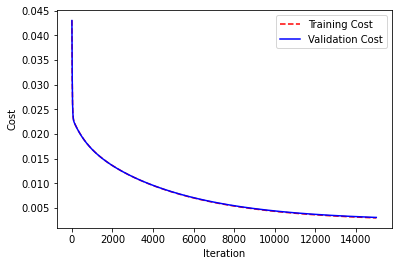

Last training cost: 0.0029425190853065507
Last validation cost: 0.0030380190735988712
Test cost: 0.005421486413982499


In [ ]:
# Visualize cost history
plot_cost_history(pr_train_history, pr_val_history)

# Print last training and validation costs + test cost
print(f'Last training cost: {pr_train_history[-1]}')
print(f'Last validation cost: {pr_val_history[-1]}')
print(f'Test cost: {J(gd_pr_theta, X_pol_test, y_test)}')

> **What are the conclusions? What are the actions after such analyses? (2-4 paragraphs)**


First, we would like to note that even though we've used the same amount of epochs, the regression took much more time to complete (375s). One of the possible explanations is that since we doubled the number of columns when we squared each one of the features and concatenated them with the originals, the algorithm takes more time to complete epochs. 

Secondly, the training and validation costs are smaller than the manual and sklearn ones. At first sight we can say that that's good. But if we look carefully, we can also note that the test cost is almost 10% bigger than the manual one, and 2% than the sklearn one. This can be a sign of overfitting. Our parameters fit better for training instances, but a little bit worse on testing instances.

Taking into account that we doubled the number of columns, and the results did not differ much, the group considers that the more complex model proved to be unnecessary, since better results were obtained with a simpler model.

---
## **Activity 4.** Hyperparameters & Normal Equation (3 points)

>**Use different Gradient Descent (GD) learning rates when optimizing. Compare the GD-based solutions with Normal Equation. You should implement your solutions. What are the conclusions?**

### **4.1.** Normal equation.

In the last activities we used fixed hyperparameters (learning rate and batch size) expecting it would bring good results, but we're finding it a bit hard to evaluate if the results are indeed good. The normal equation, vectorized below, can help in that evaluation, as in theory it returns the optimal model parameters ($\theta$). 

\begin{align}
\theta & = (\hat{X}^T \cdot \hat{X})^{-1} \cdot \hat{X}^T \cdot y
\end{align}

[Click here](https://ayearofai.com/rohan-3-deriving-the-normal-equation-using-matrix-calculus-1a1b16f65dda) for details on how this equation is obtained.

In [ ]:
# Define normal equation function
normal_eq = lambda X_hat, y: np.linalg.inv(X_hat.T @ X_hat) @ X_hat.T @ y

# Get parameters
start = time()
opt_theta = normal_eq(X_hat, y)
print(f'Optimal parameters obtained after {time() - start}s.')

# Re-label indexes, as the labels are lost when we apply the normal equation 
opt_theta.index = gd_lr_theta.index

Optimal parameters obtained after 0.05561542510986328s.


It's evident how much faster it is to calculate $\theta$ with the normal equation. We'll now compare the parameters returned by it with the ones returned by the gradient descent method at activity 1, as well as the model costs with these parameters.

In [ ]:
# Print parameters
print(f'Normal equation parameters:\n{opt_theta}\n')
print(f'Gradient descent parameters:\n{gd_lr_theta}\n')

# Print normal equation costs
print(
    'Normal equation training cost: ' +
    f'{J(opt_theta, X_hat, y)} ' +
    f'(GD: {lr_train_history[-1]})'
)
print(
    'Normal equation test cost: ' +
    f'{J(opt_theta, X_hat_test, y_test)} ' +
    f'(GD: {J(gd_lr_theta, X_hat_test, y_test)})'
)

Normal equation parameters:
intercept   -0.271794
carat        0.658097
cut          0.023201
color        0.091376
clarity      0.191162
depth       -0.014180
table       -0.051402
vol          1.625205
dtype: float64

Gradient descent parameters:
intercept   -0.059365
carat        0.839683
cut          0.006877
color        0.018811
clarity      0.075288
depth       -0.056210
table       -0.016425
vol          0.863519
dtype: float64

Normal equation training cost: 0.0021674635822085714 (GD: 0.0034709954557405175)
Normal equation test cost: 0.00704991571539183 (GD: 0.0049475396921107966)


It looks like the optimal parameters fit better to the training data than the GD solution, but generalize worse to the test data. This gives us more confidence about the quality of the model obtained in activity 1.

### **4.2.** Testing different hyperparameters.

Now we know that the gradient descent algorithm with the hyperparameters we chose returns a good model for the problem. But can it improve? Let's tweak these hyperparameters and see what happens.

#### **4.2.1** Batch size.

In activity 1 we run a full-batch GD, i.e., used the whole training data to update $\theta$ in each epoch. In this section, we'll test a mini-batch GD (update for one batch of examples at a time) and a stochastic GD (update for one example at a time), in order to see how each approach compare to each other. We also tweak the number of epochs to keep the number of iterations stable between the approaches.

##### **4.2.1.1** Mini-batch GD.

Here, the data is splitted into batches of 2056 examples. As more updates per epochs will happen, the number of epochs was reduced to 1000.

In [ ]:
# Run mini-batch gradient descent algorithm
sol = gd_regression(X_hat, y, batch_size=2056, n_epochs=1000)

# Detach solution
mb_gd_theta, mb_train_history, mb_val_history = sol

100%|██████████| 1000/1000 [02:17<00:00,  7.29epoch/s]


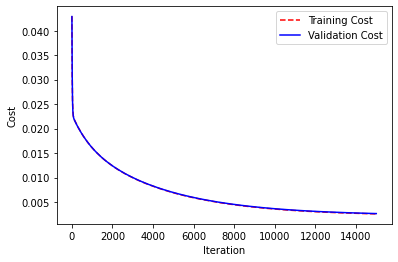

Last training cost: 0.002572214680446164
Last validation cost: 0.0026413921879656025
Test cost: 0.005259494380414103


In [ ]:
# Visualize cost history
plot_cost_history(mb_train_history, mb_val_history)

# Print last training and validation costs + test cost
print(f'Last training cost: {mb_train_history[-1]}')
print(f'Last validation cost: {mb_val_history[-1]}')
print(f'Test cost: {J(mb_gd_theta, X_hat_test, y_test)}')

##### **4.2.1.1** Stochastic GD.

Here, one update is triggered for one example in the training set at each iteration. As 30000 updates per epochs will happen, we just run 1 epoch (which still means twice as much iterations as in the previous approaches).

In [ ]:
# Run stochastic gradient descent algorithm
sol = gd_regression(X_hat, y, batch_size=1, n_epochs=1)

# Detach solution
sgd_theta, s_train_history, s_val_history = sol

100%|██████████| 1/1 [03:51<00:00, 231.42s/epoch]


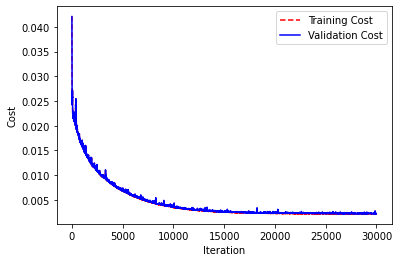

Last training cost: 0.002164419719323098
Last validation cost: 0.0022300518034152478
Test cost: 0.006831584889004863


In [ ]:
# Visualize cost history
plot_cost_history(s_train_history, s_val_history)

# Print last training and validation costs + test cost
print(f'Last training cost: {s_train_history[-1]}')
print(f'Last validation cost: {s_val_history[-1]}')
print(f'Test cost: {J(sgd_theta, X_hat_test, y_test)}')

#### **4.2.2** Learning rate.

To choose a learning rate ($\alpha$) means to find a balance between training progress and stability: a value too small can make it stuck while a value too big can make it unstable. In this section, we'll test two different $\alpha$ values from the one we used earlier ($0.01$), one bigger ($0.1$) and one smaller ($0.001$).

##### **4.2.2.1** $\alpha = 0.1$.


In [ ]:
# Run gradient descent algorithm
sol = gd_regression(X_hat, y, alpha=0.1)

# Detach solution
a0_1_gd_theta, a0_1_gd_train_history, a0_1_gd_val_history = sol

100%|██████████| 15000/15000 [04:50<00:00, 51.65epoch/s]


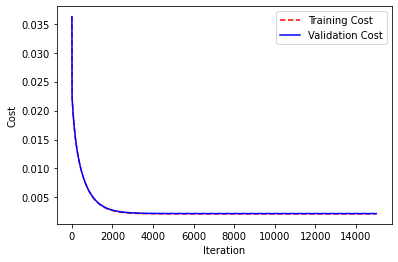

Last training cost: 0.0021484442149686017
Last validation cost: 0.002212038602066878
Test cost: 0.006662959788172206


In [ ]:
# Visualize cost history
plot_cost_history(a0_1_gd_train_history, a0_1_gd_val_history)

# Print last training and validation costs + test cost
print(f'Last training cost: {a0_1_gd_train_history[-1]}')
print(f'Last validation cost: {a0_1_gd_val_history[-1]}')
print(f'Test cost: {J(a0_1_gd_theta, X_hat_test, y_test)}')

##### **4.2.2.2** $\alpha = 0.001$.


In [ ]:
# Run gradient descent algorithm
sol = gd_regression(X_hat, y, alpha=0.001)

# Detach solution
a0_001_gd_theta, a0_001_gd_train_history, a0_001_gd_val_history = sol

100%|██████████| 15000/15000 [04:46<00:00, 52.39epoch/s]


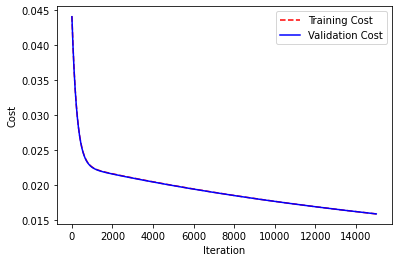

Last training cost: 0.01593979085931902
Last validation cost: 0.015940537050502357
Test cost: 0.01500575862105768


In [ ]:
# Visualize cost history
plot_cost_history(a0_001_gd_train_history, a0_001_gd_val_history)

# Print last training and validation costs + test cost
print(f'Last training cost: {a0_001_gd_train_history[-1]}')
print(f'Last validation cost: {a0_001_gd_val_history[-1]}')
print(f'Test cost: {J(a0_001_gd_theta, X_hat_test, y_test)}')

> **What are the conclusions? (2-4 paragraphs)**


On all tests (except the last one), the costs for training and validation were smaller than our first manual implementation, being closer to the optimum provided by the normal equation. But the test costs were also larger than in the first result. Just like in the previous activity, this can be interpreted as a sign of overfitting: the closer to the optimum, the better the model fits the test set, which leads to a worse generalization. It is interesting to see that our first implementation hit the best test cost overall.

The variations of $\alpha$ values also showed that our first pick was the best one in this regard. We did not calculate or test the values for this hyperparameter. We simply did some research and most of the fonts suggested the value of $0.01$. And it's also very interesting to see that our last test, with $\alpha=0.001$, hit the worst cost overall. This result showed us how important is the choice of the learning rate.

On the Stochastic GD method, we can graphically observe the fluctuation of the costs, which is also expected. The running time is also a little bit shorter. Although the test cost is slightly larger than our batch implementation, it is not as big as our last test with $\alpha=0.001$. 